# Dispersion calculation in tapered waveguide

Photonic integrated waveguides provide a versatile platform for achieving a desired dispersion profile. By controlling the waveguide cross-section geometry, it is possible to obtain zero or near-zero waveguide dispersion across a wide range of wavelengths. This capability is crucial for various applications such as optical delay lines, modulators, and supercontinuum generators, as different spectral components associated with the propagation of short optical pulses can travel at different speeds. In this example, we will build a CMOS-compatible tapered waveguide presented in `[1] N. Singh, D. Vermulen, A. Ruocco, N. Li, E. Ippen, F. X. Kärtner, and M. R. Watts. Supercontinuum generation in varying dispersion and birefringent silicon waveguide. Opt. Express 27(22), 31698-31712 (2019).`[DOI:10.1364/OE.27.031698](https://doi.org/10.1364/OE.27.031698), which demonstrates supercontinuum enhancement in varying dispersion waveguides. We will demonstrate how to utilize the `Tidy3D`'s [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html?highlight=modesolver) to compute the dispersion parameter (D) and the group-velocity dispersion (GVD) across the varying taper waveguide cross-section to replicate Figure 5 of [1].

<img src="img/tapered_waveguide_dispersion.png" width="400" alt="Tapered Waveguide Schematic">

For more integrated photonic waveguide examples such as the [Dielectric waveguide with scale-invariant effective index](https://www.flexcompute.com/tidy3d/examples/notebooks/ScaleInvariantWaveguide/), please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. Details on using the `Tidy3D`'s [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html?highlight=modesolver) can be found [here](https://www.flexcompute.com/tidy3d/examples/notebooks/ModeSolver/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import waveguide
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run_batch

## Tapered Waveguide
The tapered waveguide is 5 mm long and varies adiabatically from 0.500 $\mu m$ to 1.100 $\mu m$ in width. The rib cross-section has a total height of 0.380 $\mu m$ and a slab thickness of 0.065 $\mu m$. The waveguide is etched into a silicon thin film and is surrounded by a thick silica layer.

In [2]:
taper_w_in = 0.5  # Input taper width (um).
taper_w_out = 1.1  # Output taper width (um).
taper_l = 5000  # Taper length (um).
wg_h = 0.38  # Waveguide height (um).
wg_slab = 0.065  # Waveguide slab thickness (um).

The group-velocity dispersion (GVD) variation will be computed along the taper length at the wavelength of 1.95 $\mu m$. In addition, we will calculate the dispersion parameter (D) between the wavelength range of 1.2 $\mu m$ and 2.8 $\mu m$.

In [3]:
wl_min = 1.2  # Minimum wavelength in dispersion calculation.
wl_max = 2.4  # Maximum wavelength in dispersion calculation.
wl_steps = 21 # Number of wavelength points in mode calculation.

wl_d = np.linspace(wl_min, wl_max, wl_steps)  # Wavelength range for D calculation.
wl_gvd = np.asarray([1.95])  # Wavelength for GVD calculation.

## Simulation Setup
Now, we will build the tapered waveguide structure using a `PolySlab` and materials taken from the material library.

In [4]:
mat_si = td.material_library["cSi"]["Palik_Lossless"]
mat_sio2 = td.material_library["SiO2"]["Palik_Lossless"]

taper = td.Structure(
    geometry=td.PolySlab(
        vertices=[[0, -taper_w_in/2], [taper_l, -taper_w_out/2],
                  [taper_l, taper_w_out/2], [0, taper_w_in/2]], 
        axis=2, 
        slab_bounds=(-wg_h / 2, wg_h / 2)
    ),
    medium=mat_si,
    name="taper_core",
)

slab = td.Structure(
    geometry=td.Box(center=[0, 0, -wg_h / 2 + wg_slab / 2], size=[td.inf, td.inf, wg_slab]),
    medium=mat_si,
    name="taper_slab",
)

sim = td.Simulation(
    center=(taper_l/2, 0, 0),
    size=(1.1 * taper_l, taper_w_out + wl_max, 3),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=wl_min),
    structures=[taper, slab],
    run_time=1e-12,
    medium=mat_sio2,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
    symmetry=(0, -1, 0),
)

To ensure the simulation is correctly defined, we will visualize the permittivity distribution. As expected, we see the tapered waveguide profile along the `x`-direction and the rib cross-section in the `yz` plane.

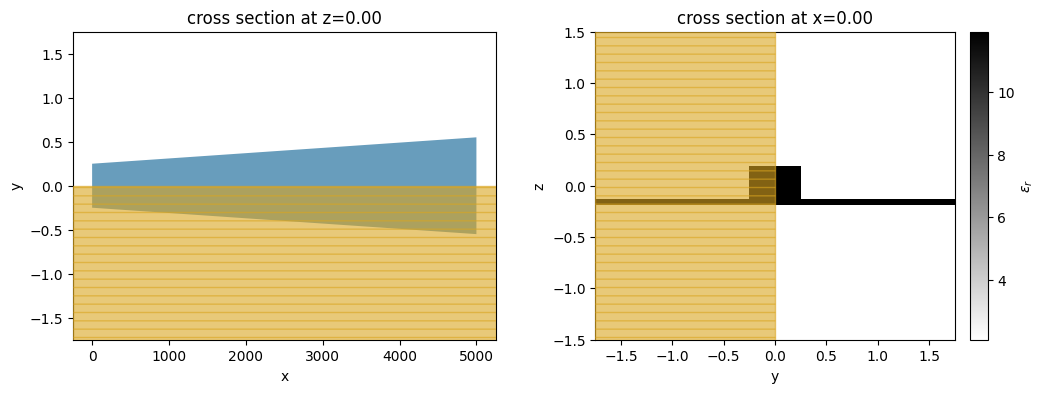

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sim.plot(z=0, ax=ax[0])
ax[0].set_aspect("auto")

sim.plot_eps(x=0, freq=td.C_0 / wl_gvd[0], ax=ax[1])
plt.show()

As we need to run the mode solver several times, we will create a helper function called `build_mode`. This function takes the arguments `mode_pos_x`, `wl`, `num_modes`, and `group_index_step`, and builds the `ModeSolver`. We plan to use this function to conduct a sweep on the mode plane position along the tapered waveguide to calculate the parameters D and GVD.

In [6]:
def build_mode(mode_pos_x: float=0, 
             wl: np.array=wl_d, 
             num_modes: int=1, 
             group_index_step: float=0.15) -> td.ModeData:
    """Builds a ModeSolver object."""
    
    freqs = td.C_0 / wl  # Mode frequencies.

    # Mode specification.    
    mode_spec = td.ModeSpec(num_modes=num_modes, 
                            group_index_step=group_index_step,
                            num_pml=[7, 7],)

    # Build a mode solver.
    mode_solver = ModeSolver(
        simulation=sim,
        plane=td.Box(center=(mode_pos_x, 0, 0), size=(0, td.inf, td.inf)),
        mode_spec=mode_spec,
        freqs=freqs,
    )

    return mode_solver

## Group Index Step Convergence
According to `[2] G. Agrawal. Nonlinear Fiber Optics (5th Ed.), Academic Press (2013)`, the effects of fiber dispersion are addressed by expanding the mode-propagation constant $\beta$ in a Taylor series around the angular frequency $\omega$. As a result, the parameters $\beta_{1}$ and $\beta_{2}$ are directly linked to the mode's effective index $n_{eff}(\omega)$ and its derivatives as

$$\beta_{1} = \frac{1}{v_{g}} = \frac{n_{g}}{c} = \frac{1}{c}\left(n_{eff} + \omega\frac{d n_{eff}}{d\omega}\right)$$

and

$$\beta_{2} = \frac{1}{c}\left(2\frac{d n_{eff}}{d\omega} + \omega\frac{d^{2} n_{eff}}{d\omega^{2}}\right),$$

where $c$ is the speed of light, $v_{g}$ is the group velocity, and $n_{g}$ is the group index. The first-order term $\beta_{1}$ controls the speed at which the optical pulse envelope propagates, and the group velocity dispersion (GVD) parameter $\beta_{2}$ represents dispersion of the group velocity and is responsible for pulse broadening. In practice, the dispersion parameter D, which is defined as $d\beta_{1}/d\lambda$, is also used to quantify dispersion. It is related to $\beta_{2}$ by

$$D = -\frac{2\pi c}{\lambda^{2}}\beta_{2},$$

where $\lambda$ is the light wavelength.

Before proceeding with the main analyses, we will verify the convergence of our dispersion calculation with respect to the `group_index_step` parameter, which determines the fractional frequency step used in the numerical differentiation of the effective index. 

We will build a Mode Solver list to create a simulation batch as we run many mode solver calculations.

In [7]:
# List of group_index_step values.
gis_values = [0.02, 0.05, 0.10, 0.15, 0.20]

# Mode sweep over the group_index_step values.
mode_gis = []
for gis in gis_values:
    mode_gis.append(build_mode(mode_pos_x=taper_l/2, group_index_step=gis))

Once the list of Mode Solvers is created, we simply use the `run_batch()` method to run the entire batch of tasks in parallel.

In [8]:
#  Run the mode solvers in parallel.
batch_gis = run_batch(
    mode_solvers=mode_gis,  # List of mode solvers.
    task_name="data/tapered_wg_mode",  # Each task in the batch will have a unique index appended to this base name.
    folder_name="Mode Solver",  # Name of the folder where tasks are stored on the server's web UI.
    results_files=[
        f"./data/gis_{gis:.2f}.hdf5" for gis in gis_values
    ],  # List of file paths where the results are downloaded.
)

22:25:43 -03 Running a batch of 5 mode solvers.                                 
             

Output()

22:27:51 -03 A batch of `ModeSolver` tasks completed successfully!

We can observe that a `group_index_step` value between 0.10 and 0.15 is enough to obtain a smooth dispersion curve, avoiding the numerical noise created in smaller `group_index_step` values.

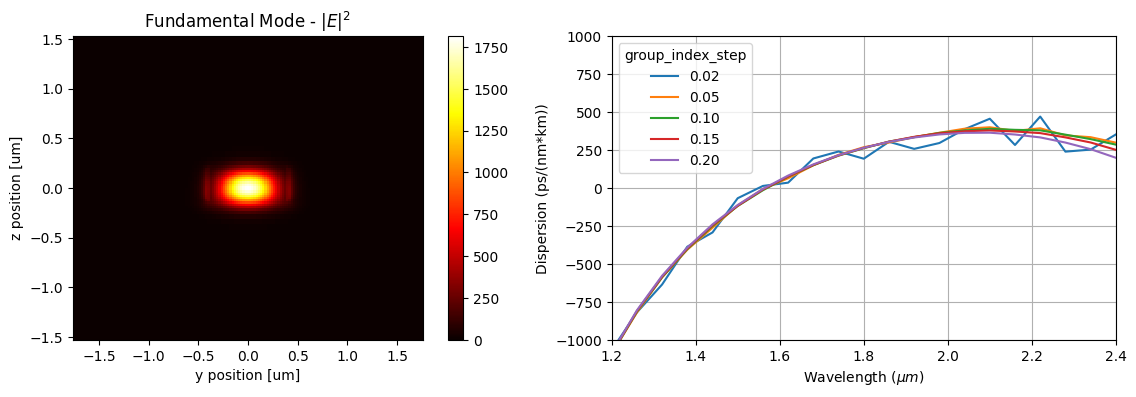

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

batch_gis[0].intensity.isel(f=batch_gis[0].modes_info["f"].size//2, mode_index=0).plot(x='y', y='z', cmap="hot", ax=ax[0])
ax[0].set_title("Fundamental Mode - $|E|^{2}$")
ax[0].set_aspect("equal")

for gis, md in zip(gis_values, batch_gis):
    ax[1].plot(td.C_0 / md.modes_info["f"].squeeze(drop=True).values, 
               md.modes_info["dispersion (ps/(nm km))"].squeeze(drop=True).values, 
               label=f"{gis:.2f}")
ax[1].set_ylabel("Dispersion (ps/(nm*km))")
ax[1].set_xlabel("Wavelength ($\\mu m$)")
ax[1].set_ylim([-1000, 1000])
ax[1].set_xlim([wl_d[0], wl_d[-1]])        
ax[1].legend(title="group_index_step")
ax[1].grid()
plt.show()    

## Dispersion Parameters Calculation
Now, we are ready to calculate the dispersion parameters for the varying waveguide cross-sections along the taper length. To reproduce Figure 5(a) of [1], we will calculate the $\beta_{2}$ parameter of GVD at the wavelength of 1.95 $\mu m$ for waveguide cross-sections ranging from 0.5 $\mu m$ to 1.1 $\mu m$ in intervals of 0.2 $\mu m$. 

In [10]:
x_values_gvd = np.linspace(0.05, taper_l - 0.05, 13)

# Mode simulations to calculate beta2 of GVD.
mode_gvd = []
for x in x_values_gvd:
    mode_gvd.append(build_mode(mode_pos_x=x, wl=wl_gvd, group_index_step=0.15))

In [11]:
#  Run the mode solvers in parallel.
batch_gvd = run_batch(
    mode_solvers=mode_gvd,  # List of mode solvers.
    task_name="data/tapered_wg_mode",  # Each task in the batch will have a unique index appended to this base name.
    folder_name="Mode Solver",  # Name of the folder where tasks are stored on the server's web UI.
    results_files=[
        f"./data/x_{x:.2f}.hdf5" for x in x_values_gvd
    ],  # List of file paths where the results are downloaded.
)

22:29:54 -03 Running a batch of 13 mode solvers.                                
             

Output()

22:30:50 -03 A batch of `ModeSolver` tasks completed successfully!

In [12]:
# Mode simulations to calculate beta2 of GVD.
data_gvd = []
for md in batch_gvd:
    d = md.modes_info["dispersion (ps/(nm km))"].squeeze(drop=True).values
    beta2 = - ((d * wl_gvd **2) / (2 * np.pi * td.C_0)) * 1e12    
    data_gvd.append(beta2) 

 Afterward, considering seven positions along the taper length, we will calculate the dispersion parameter D for wavelengths ranging from 1.2 $\mu m$ to 2.4 $\mu m$. We will use this data to plot Figure 5(b) of [1].   

In [13]:
x_values_d = np.linspace(0.05, taper_l - 0.05, 7)

# Mode simulations to calculate D.
mode_d = []
for x in x_values_d:
    mode_d.append(build_mode(mode_pos_x=x, group_index_step=0.1))

In [14]:
#  Run the mode solvers in parallel.
batch_d = run_batch(
    mode_solvers=mode_d,  # List of mode solvers.
    task_name="data/tapered_wg_mode",  # Each task in the batch will have a unique index appended to this base name.
    folder_name="Mode Solver",  # Name of the folder where tasks are stored on the server's web UI.
    results_files=[
        f"./data/x_{x:.2f}.hdf5" for x in x_values_d
    ],  # List of file paths where the results are downloaded.
)

22:31:43 -03 Running a batch of 7 mode solvers.                                 
             

Output()

22:34:52 -03 A batch of `ModeSolver` tasks completed successfully!

In [15]:
data_d = []
for md in batch_d:
    data_d.append(md.modes_info["dispersion (ps/(nm km))"].squeeze(drop=True).values)

Lastly, we will plot GVD and D dispersion parameters. We can observe a good agreement between the simulations and Figure 5(a-b).

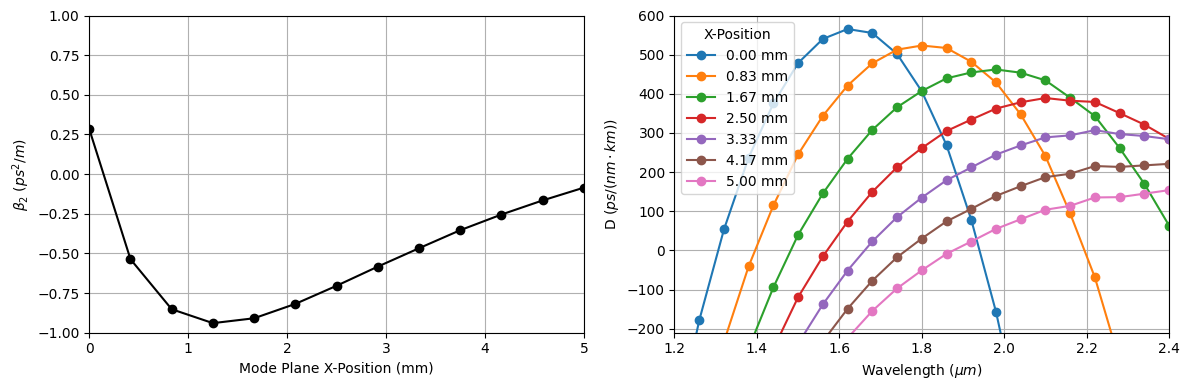

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

# GVD
ax[0].plot(x_values_gvd / 1000, data_gvd, "ok-")
ax[0].set_ylabel("$\\beta_{2}$ ($ps^{2}/m$)")
ax[0].set_xlabel("Mode Plane X-Position (mm)")
ax[0].set_ylim([-1, 1])
ax[0].set_xlim([0, 5])        
ax[0].grid()

# D
for l, d in zip(x_values_d, data_d):
    ax[1].plot(wl_d, d, "-o", label=f"{l /1000:.2f} mm")
ax[1].set_ylabel("D ($ps/(nm \\cdot km)$)")
ax[1].set_xlabel("Wavelength ($\\mu m$)")
ax[1].set_ylim([-210, 600])
ax[1].set_xlim([1.2, 2.4])        
ax[1].legend(title="X-Position")
ax[1].grid()
plt.show() 